# Big Traces

This notebook is more optimized for handling large traces and focuses on easy to compute plots and metrics.

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import pathlib
import matplotlib
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d
import statistics
from sortedcontainers import SortedList, SortedDict
import time
from scipy import stats
import pprint
from functools import total_ordering

In [117]:
DATA_DIR = 'parrot-traces-polysmall'

In [118]:
FILES    = [p.absolute() for p in pathlib.Path(DATA_DIR).iterdir()]

@total_ordering
class trace:
    def __init__(self, path):
        self.path = path
        self.name = path.stem.split('_')[2]
    def load(self):
        return pd.read_csv(self.path, delim_whitespace=True)
    def loadLat(self):
        return np.array(pd.read_csv(self.path, delim_whitespace=True)['latency_nano'])
    def __repr__(self):
        return self.name
    def __lt__(self, obj):
        return ((self.name) < (obj.name))
    def __eq__(self, obj):
        return (self.name == obj.name)
    
TRACES  = sorted([trace(f) for f in FILES])

In [119]:
print('Directory:'.ljust(10), DATA_DIR)
print('Files:'.ljust(10), *TRACES)

Directory: parrot-traces-polysmall
Files:     atax bicg deriche durbin gemver gesummv jacobi-1d mvt trisolv


In [120]:
a = TRACES[3].loadLat()

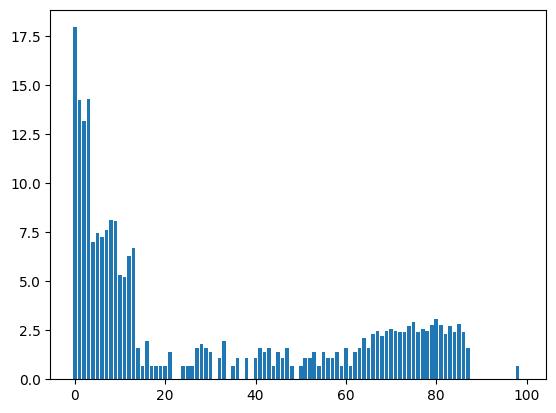

In [121]:
his,_ = np.histogram(a,bins=100)
np.seterr(divide = 'ignore')
fig, ax = plt.subplots()
#ax.hist(a[a>4], bins=100)
ax.bar([*range(len(his))],np.log(his))
plt.show()

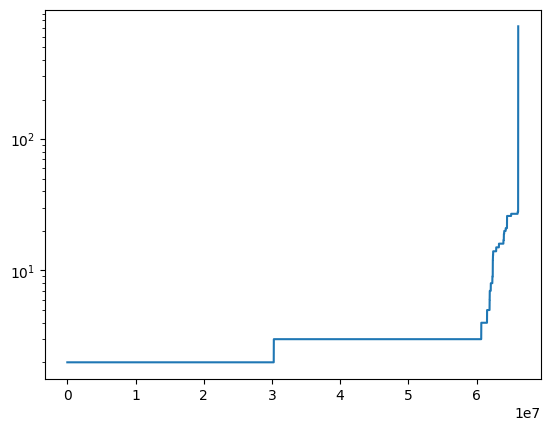

In [122]:
fig, ax = plt.subplots()
ax.semilogy(sorted(a))

In [123]:
#ss = len(str(len(a)))+2
#print(*[label.ljust(ss) for label in ['len', '<3']])
#print(*[str(datapoint).ljust(ss) for datapoint in [len(a), len(a[a<3]), len(a[a<3])/len(a)*100]])

print(f'Length: {len(a)}')
print(f'% < 3 : {len(a[a<3])/len(a):.2f}')
print(f'% < 4 : {len(a[a<4])/len(a):.2f}')
print(f'% < 5 : {len(a[a<5])/len(a):.2f}')

print(f'% < 6 : {len(a[a<6])/len(a):.2f}')
print(f'% < 7 : {len(a[a<7])/len(a):.2f}')
print(f'% < 8 : {len(a[a<8])/len(a):.2f}')


Length: 66106136
% < 3 : 0.46
% < 4 : 0.92
% < 5 : 0.93
% < 6 : 0.94
% < 7 : 0.94
% < 8 : 0.94


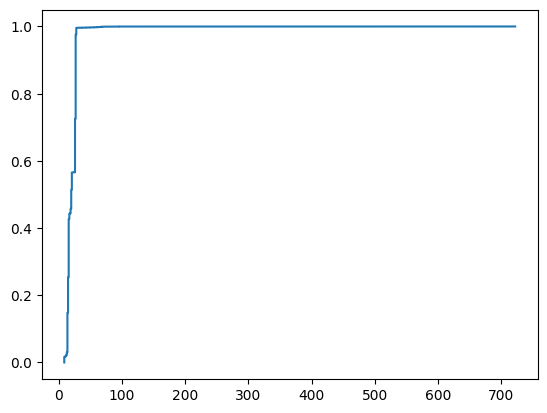

In [124]:
fig, ax = plt.subplots()
ecdf = ECDF(a[a>8])
ax.plot(ecdf.x, ecdf.y)
plt.show()

In [125]:
np.mean(a)

3.620457017787275

In [126]:
np.mean(np.random.choice(a, 1000000))

3.61458

In [132]:
tr = TRACES[0:2]

for t in tr:
    print(max(t.load()['phase']))

1
1


In [131]:
TRACES[0].load().columns

Index(['phase', 'rwf', 'threadID', 'addr', 'latency_nano'], dtype='object')

Overall: 3.62
Per-interval


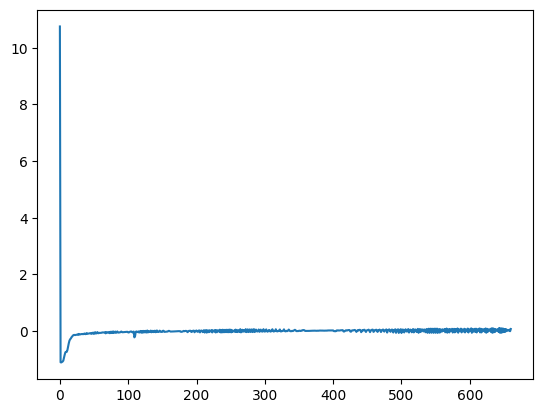

In [175]:
ov = np.mean(a)
print(f'Overall: {ov:.2f}')
print(f'Per-interval')

intlen = 100000
intervals = len(a)//intlen
peri = [np.mean(a[i*intlen : (i+1)*intlen]) for i in range(intervals)]
#print(peri)

fig, ax = plt.subplots()
#ax.plot(peri)
#ax.hlines(y=ov, xmin=0, xmax=intervals, linewidth=2, color='r')

# Error plot
ax.plot(peri-ov)

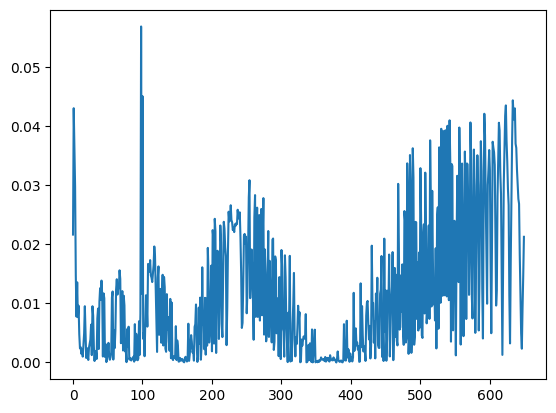

In [177]:
def abspctchange(old, new):
    return np.abs((old - new) / old)
pc = [abspctchange(peri[i], peri[i+1]) for i in range(len(peri)-1)]
#print(np.array(pc) < 0.05)
#plt.plot(pc[10:]) 

1.0

In [174]:
print(TRACES[3])

durbin


[130321, 43990309, 44030314, 44040315, 44080316, 44100313, 44150301, 44170313, 44210322, 44240323, 44280312, 44300310, 44350321, 44370313, 44420320, 44440318, 44480315, 44510319, 44550309, 44570323, 44620311, 44640323, 44680309, 44710305, 44750313, 44780323, 44820323, 44840323, 44890321, 44910309, 44950316, 44980312, 45020319, 45040321, 45090323, 45110317, 45150304, 45180316, 45220311, 45250315, 45290309, 45310317, 45360317, 45380311, 45420322, 45450308, 45490310, 45510314, 45560309, 45580324, 45630317, 45650312, 45690323, 45720313, 45760318, 45780318, 45830317, 45850323, 45890323, 45920320, 45960314, 45980323, 46030306, 46050309, 46100315, 46120321, 46160311, 46190323, 46230322, 46250323, 46300307, 46320307, 46360317, 46390323, 46430317, 46460323, 46500318, 46520311, 46570312, 46590307, 46630321, 46660312, 46700315, 46720317, 46770322, 46790313, 46830306, 46860313, 46900323, 46930323, 46970317, 46990323, 47040320, 47060317, 47100296, 47130320, 47170305, 47190318, 47240320, 47260317, 4

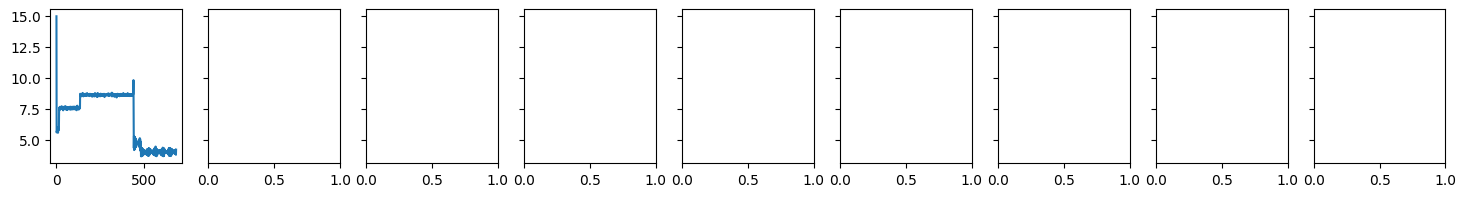

In [201]:
def get_phase_changes(phases):
    pc = []
    for i in range(len(phases)-1):
        if phases[i] != phases[i+1]:
            pc.append(i)
    return pc

def pl_latency_over_time(ax, t, interval_len):
    #ov = np.mean(series)
    print(f'loading {t.name}')
    df = t.load()
    series = df['latency_nano']
    #print('doing get_phase_changes')
    #pc = get_phase_changes(df['phase'])
    #print(pc)
    #print(np.array(pc) // interval_len)
    nintervals = len(series)//interval_len
    peri = [np.mean(series[i*interval_len : (i+1)*interval_len]) for i in range(nintervals)]
    ax.plot(peri)
    

fig, axs = plt.subplots(ncols=len(TRACES), sharey=True)
for i, t in enumerate(TRACES[:1]):
    pl_latency_over_time(axs[i], t, 100000)

fig.set_size_inches((2*len(TRACES), 2))
plt.show()

In [200]:
for t in TRACES:
    print(f'{t.name} {max(t.load()["phase"])}')
    


atax 1
bicg 1
deriche 0
durbin 0
gemver 0
gesummv 1
jacobi-1d 0
mvt 0
trisolv 1
